In [190]:
import msprime 
import torch 
import torch_geometric
from torch_geometric.utils import remove_self_loops, from_networkx, remove_isolated_nodes
from torch_geometric.data import Data
import numpy as np
import seaborn as sns
import networkx as nx

In [16]:
def rename_data_attribute(obj, old_name, new_name):
    obj.__dict__['_store'][new_name] = obj.__dict__['_store'].pop(old_name)

In [3]:
sample_size=10
L = 10**8
r = 0.5 * 1e-8
s = 1

Ne=10**4
demography=msprime.Demography()
demography.add_population(initial_size=(Ne))

for x in range(0,1):
    ts=msprime.sim_ancestry(samples=sample_size,
                            recombination_rate=r,
                            sequence_length=L,
                            demography=demography,
                            ploidy=1 ,
                            model=[msprime.SweepGenicSelection(position=(L/2), start_frequency=(1/Ne),end_frequency=0.99,s=s,dt=(1/(40*Ne))),
                                   msprime.StandardCoalescent()],
                            random_seed=((s*x*10+3)**2)
                           )

In [5]:
def get_population_time(time_rate:float=0.06, tmax:int = 130_000,
                        num_time_windows:int = 21
                       ) -> np.array :
    """Creates population time points; used as time points to change
    population size changes for simulation
    
    :return numpy.ndarray: time points of length num_time_windows
    """
    
    population_time = np.repeat([(np.exp(np.log(1 + time_rate * tmax) * i /
                              (num_time_windows - 1)) - 1) / time_rate for i in
                              range(num_time_windows)], 1, axis=0)
    population_time[0] = 1
    return population_time

def get_new_poptime():
    steps = 18
    x = np.log(get_population_time(time_rate=0.1, num_time_windows=steps, tmax=10_000_000).tolist())
    xnew = np.linspace(x[0], x[-1], num=10000, endpoint=True)
    x_sample = xnew[np.linspace(10, 9999, 60).astype(int)]
    population_time = np.exp(x_sample)
    return population_time

In [6]:
population_time = get_new_poptime()

<AxesSubplot:>

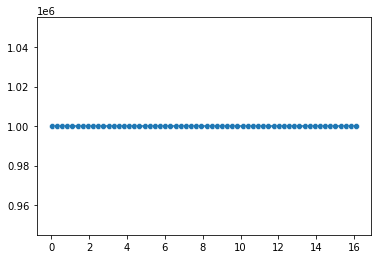

In [7]:
sns.lineplot(x=np.log(population_time), y=1e6)
sns.scatterplot(x=np.log(population_time), y=1e6)

In [8]:
trees = ts.aslist()

In [231]:
def add_mmc_events(edge_index1, edge_index2, do_node1, do_node2):
    for i, edge in enumerate(edge_index1):
        if edge == do_node2:
            edge_index1[i] = do_node1

    for i, edge in enumerate(edge_index2):
        if edge == do_node2:
            edge_index2[i] = do_node1
            
    return edge_index1, edge_index2


def torch_delete(tensor, indices):
    mask = torch.ones(tensor.numel(), dtype=torch.bool)
    mask[indices] = False
    return tensor[mask]

def old_datatize_trees(tree):
    G = nx.Graph(tree.as_dict_of_dicts())
    #mapping_dict = {i: x for i, x in enumerate(list(G.nodes()))}
    data_object = from_networkx(G)
    rename_data_attribute(data_object, "branch_length", "edge_weight") 
    #data_object.mapping_dict = mapping_dict
    return data_object


def datatize_trees(tree):
    G = nx.DiGraph(tree.as_dict_of_dicts())
    mapping_dict = {i: x for i, x in enumerate(list(G.nodes()))}
    data_object = from_networkx(G)
    rename_data_attribute(data_object, "branch_length", "edge_weight") 
    data_object.mapping_dict = mapping_dict
    return data_object

def undirect(do):

    edge_index0 = do.edge_index[0] 
    edge_index1 = do.edge_index[1] 
    new_edge_index0 = torch.cat([edge_index0, edge_index1])
    new_edge_index1 = torch.cat([edge_index1, edge_index0])
    edge_index = torch.stack([new_edge_index0, new_edge_index1])
    edge_weight = torch.cat([do.edge_weight, do.edge_weight])

    num_nodes = int(edge_weight.shape[0] / 2)
    num_nodes = torch.Tensor([num_nodes]).long()[0] + 1
 
    do = Data(edge_index=edge_index, edge_weight=edge_weight, num_nodes=num_nodes)
    
    return do


def multiple_mergerize(tree):
    
    data_object = datatize_trees(tree)
    mapping_dict = data_object.mapping_dict
    node_times1 = [tree.get_time(data_object.mapping_dict[key]) for key in data_object.edge_index[0].tolist()]
    node_times2 = [tree.get_time(data_object.mapping_dict[key]) for key in data_object.edge_index[1].tolist()]
    count_node1, _ = np.histogram(node_times1, bins=population_time)
    count_node2, _ = np.histogram(node_times2, bins=population_time)
    dg_node_times1 = np.digitize(node_times1, bins=population_time)
    dg_node_times2 = np.digitize(node_times2, bins=population_time)
    mmc_events = np.argwhere(dg_node_times1 == dg_node_times2).T[0].tolist()
    edge_index1 = data_object.edge_index[0]
    edge_index2 = data_object.edge_index[1]
    edge_weight = data_object.edge_weight

    if len(mmc_events) > 0:

        for mmc_event in mmc_events:
            do_node1, do_node2 = edge_index1[mmc_event].item(), edge_index2[mmc_event].item()
            edge_index1, edge_index2 = add_mmc_events(edge_index1, edge_index2, do_node1, do_node2)
        loops = np.argwhere(edge_index1 == edge_index2).T[0].tolist()
        edge_index1 = torch_delete(edge_index1, loops)
        edge_index2 = torch_delete(edge_index2, loops)
        edge_weight = torch_delete(edge_weight, loops)
        data_object = Data(edge_index = torch.stack([edge_index1, edge_index2]), edge_weight=edge_weight)
        data_object.edge_index, data_object.edge_weight = remove_self_loops(data_object.edge_index, data_object.edge_weight)
        
    data_object.mapping_dict = None
    num_nodes = torch.Tensor([len(data_object.edge_weight)]).long()[0] + 1
    data_object.num_nodes = num_nodes
    data_object = undirect(data_object)
    data_object.edge_index, data_object.edge_weight, _  = remove_isolated_nodes(edge_index=data_object.edge_index, edge_attr=data_object.edge_weight)
    return data_object

#data_objects = [multiple_mergerize(tree) for tree in ts.trees()]

In [172]:
def plot_data_object(data_object):
    edge_index = data_object.edge_index
    g = torch_geometric.utils.to_networkx(data_object, to_undirected=True)
    nx.draw(g, with_labels=True)

In [221]:
tree = trees[1000]

In [222]:
data_object_before = old_datatize_trees(tree); data_object_before

Data(edge_index=[2, 36], num_nodes=19, edge_weight=[36])

In [223]:
data_object_after = multiple_mergerize(tree); data_object_after

[3]


Data(edge_index=[2, 34], edge_weight=[34], num_nodes=18)

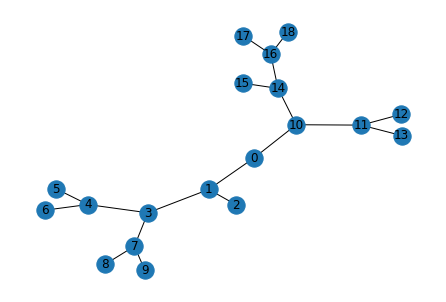

In [224]:
plot_data_object(data_object_before);

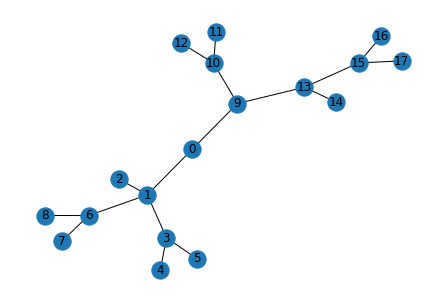

In [225]:
plot_data_object(data_object_after)

In [235]:
def get_tree_starting_positions(ts):
    tree_starting_positions = []
    for tree in ts.trees():
        left = tree.interval.left
        tree_starting_positions.append(left)
    return tree_starting_positions

In [236]:
tree_starting_positions = get_tree_starting_positions(ts)

In [232]:
data_objects = [multiple_mergerize(tree) for tree in ts.trees()]

In [239]:
num_nodes = [do.num_nodes.item() for do in data_objects]

<AxesSubplot:>

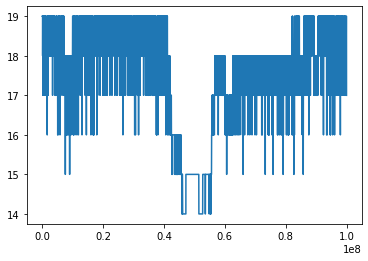

In [241]:
sns.lineplot(x=tree_starting_positions, y=num_nodes)